# Mini-projet n°1 – Chats ou Chiens ?

In [46]:
#Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout,  GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, clone_model, Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 


In [77]:
[k.device_type for k in tf.config.list_physical_devices()]

['CPU', 'GPU']

In [81]:
df = pd.read_csv(
    "./oxford-iiit-pet/annotations/list.txt",
    sep=r"\s+",                                         
    comment="#",                                        
    header=None,                                        
    names=["Image", "CLASS_ID", "SPECIES", "BREED_ID"]
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7349 entries, 0 to 7348
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     7349 non-null   object
 1   CLASS_ID  7349 non-null   int64 
 2   SPECIES   7349 non-null   int64 
 3   BREED_ID  7349 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 229.8+ KB


Le jeu de données est composé de 7349 individus.
Les variables sont les suivantes :
- Image : au format .jpg ;
- CLASS\_ID (race) : 37 races différentes ;
- SPECIES : chat ou chien (1 ou 2 selon l'espèce) ;
- BREED\_ID : identifiant de la race parmi l'espèce concernée.

Afin de rendre les données plus lisibles, nous rajoutons deux variables non numériques précisant les noms de l'espèce (SPECIES\_NAME) et de la race (BREED\_NAME) de chaque individu.

In [82]:
df["BREED_NAME"] = df["Image"].str.rsplit("_", n=1).str[0]           # Nom de la race
df["SPECIES_NAME"] = df["SPECIES"].map({1: "Cat", 2: "Dog"})         # Chat ou chien
df["Image"] = df["Image"].apply(lambda x: f"{x}.jpg")

print(df.sample(n=3, random_state=42))

                      Image  CLASS_ID  SPECIES  BREED_ID      BREED_NAME  \
2755       keeshond_164.jpg        19        2        13        keeshond   
2966   newfoundland_178.jpg        23        2        16    newfoundland   
5186  great_pyrenees_31.jpg        16        2        10  great_pyrenees   

     SPECIES_NAME  
2755          Dog  
2966          Dog  
5186          Dog  


### Étude de la répartition par race et par type


SPECIES_NAME
Dog    4978
Cat    2371
Name: count, dtype: int64

Pourcentages:
SPECIES_NAME
Dog    67.737107
Cat    32.262893
Name: count, dtype: float64


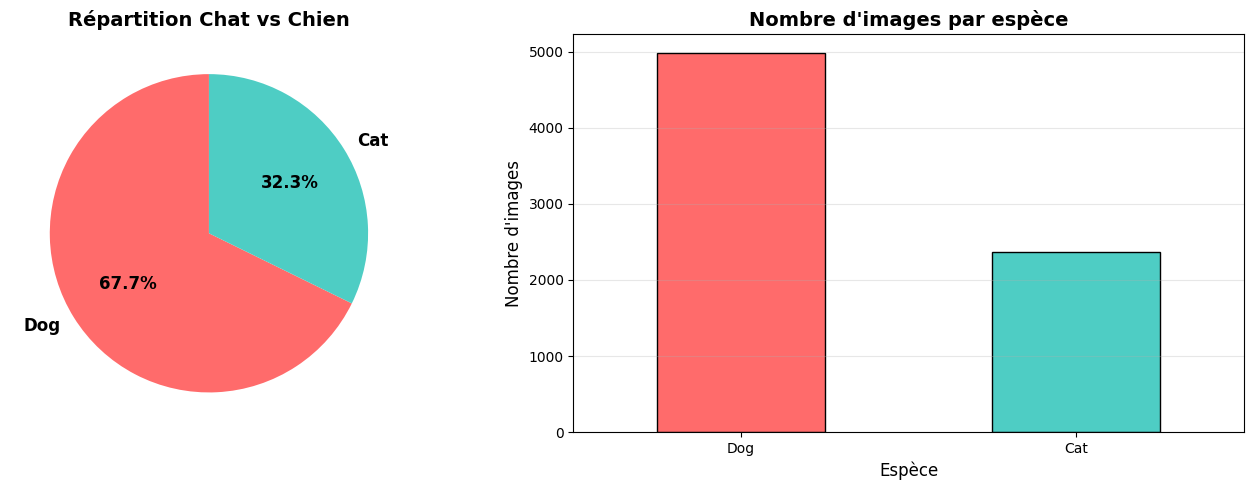

In [49]:
species_counts = df["SPECIES_NAME"].value_counts()
print(f"\n{species_counts}")
print(f"\nPourcentages:")
print(species_counts / len(df) * 100)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#FF6B6B', '#4ECDC4']
axes[0].pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
axes[0].set_title('Répartition Chat vs Chien', fontsize=14, weight='bold')

# Bar chart
species_counts.plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title('Nombre d\'images par espèce', fontsize=14, weight='bold')
axes[1].set_xlabel('Espèce', fontsize=12)
axes[1].set_ylabel('Nombre d\'images', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Nombre total de races: 37

Top 10 races les plus représentées:
BREED_NAME
american_bulldog             200
basset_hound                 200
american_pit_bull_terrier    200
beagle                       200
Bengal                       200
yorkshire_terrier            200
Birman                       200
chihuahua                    200
British_Shorthair            200
havanese                     200
Name: count, dtype: int64

Top 10 races les moins représentées:
BREED_NAME
Siamese                       199
boxer                         199
keeshond                      199
scottish_terrier              199
Abyssinian                    198
english_cocker_spaniel        196
newfoundland                  196
Egyptian_Mau                  190
staffordshire_bull_terrier    189
Bombay                        184
Name: count, dtype: int64

📈 Statistiques:
Moyenne d'images par race: 198.62
Médiane: 200.00
Écart-type: 3.52
Min: 184 | Max: 200


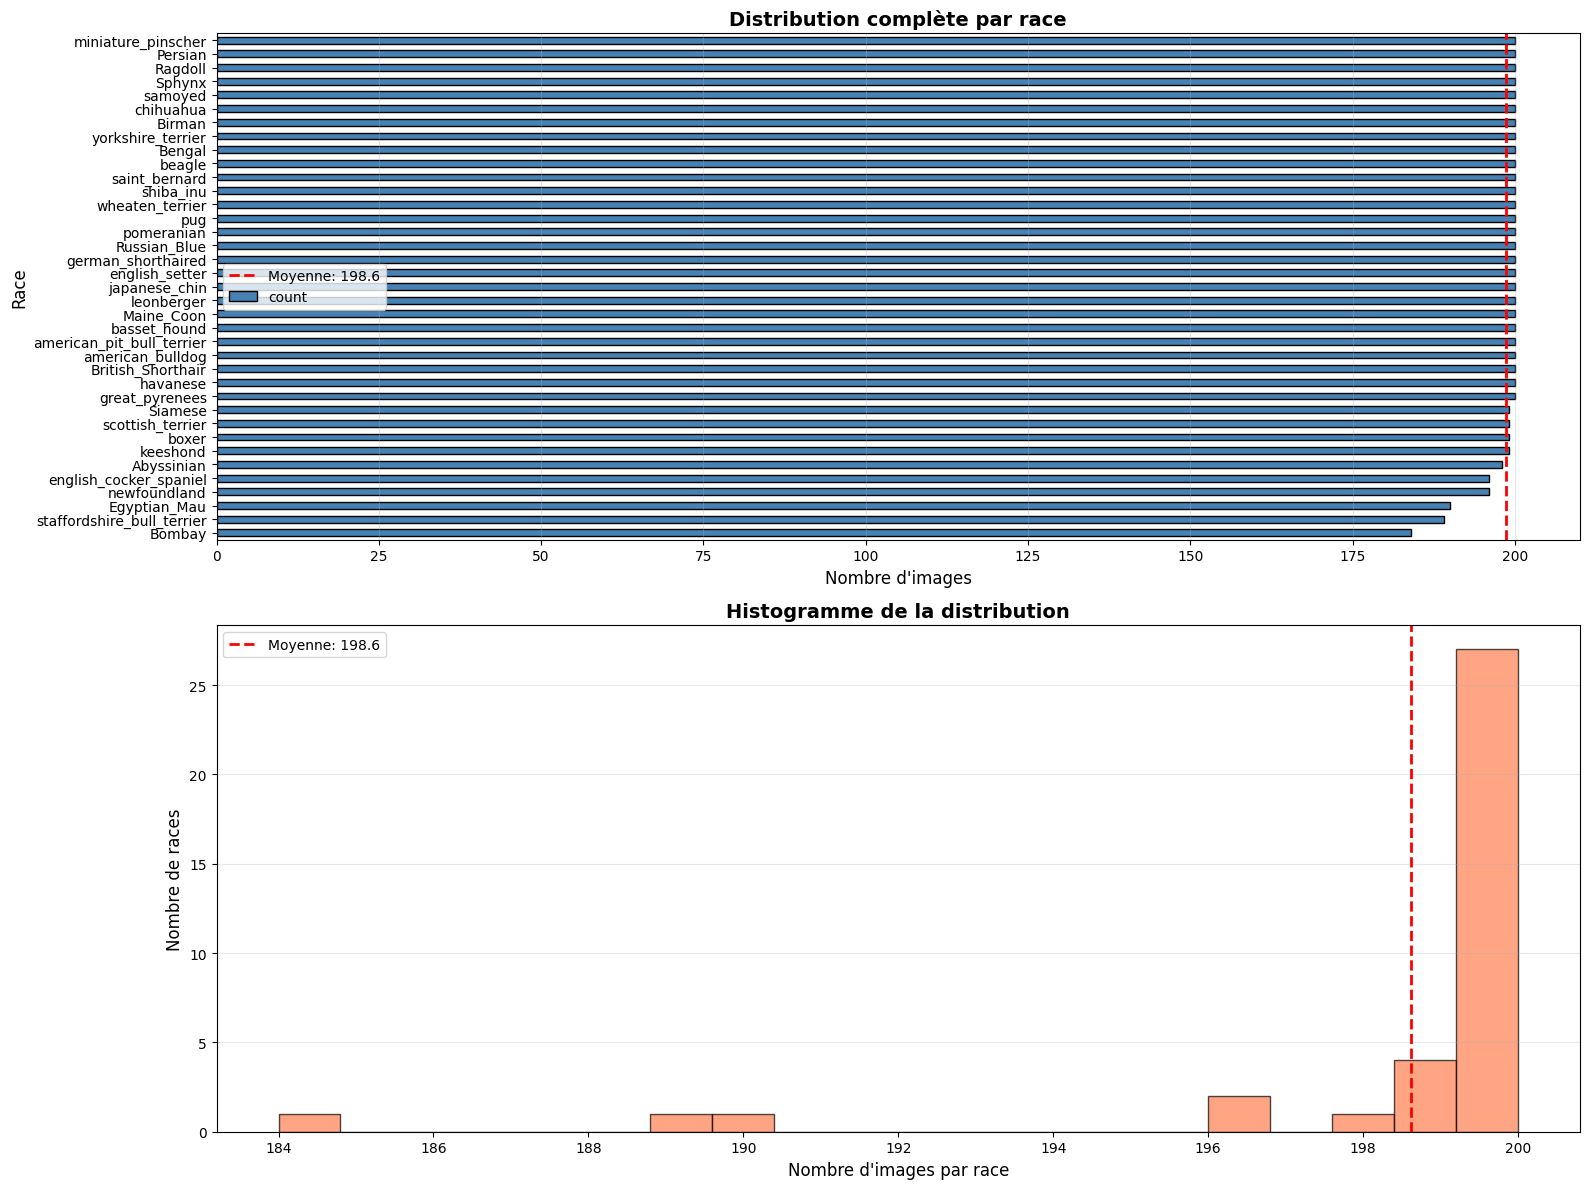

In [50]:
breed_counts = df["BREED_NAME"].value_counts().sort_values(ascending=False)
print(f"\nNombre total de races: {len(breed_counts)}")
print(f"\nTop 10 races les plus représentées:")
print(breed_counts.head(10))
print(f"\nTop 10 races les moins représentées:")
print(breed_counts.tail(10))

# Statistiques
print(f"\n📈 Statistiques:")
print(f"Moyenne d'images par race: {breed_counts.mean():.2f}")
print(f"Médiane: {breed_counts.median():.2f}")
print(f"Écart-type: {breed_counts.std():.2f}")
print(f"Min: {breed_counts.min()} | Max: {breed_counts.max()}")

# Visualisation complète
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Toutes les races
breed_counts.sort_values().plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Distribution complète par race', fontsize=14, weight='bold')
axes[0].set_xlabel('Nombre d\'images', fontsize=12)
axes[0].set_ylabel('Race', fontsize=12)
axes[0].axvline(x=breed_counts.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Moyenne: {breed_counts.mean():.1f}')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Histogramme de la distribution
axes[1].hist(breed_counts, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Histogramme de la distribution', fontsize=14, weight='bold')
axes[1].set_xlabel('Nombre d\'images par race', fontsize=12)
axes[1].set_ylabel('Nombre de races', fontsize=12)
axes[1].axvline(x=breed_counts.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Moyenne: {breed_counts.mean():.1f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Le nombre d'individus est environ le même pour chaque race (200). Les données semblent a priori équilibré,  même si certaines races (Bombay, chat) n'ont pas autant d'individus que les autres.
On peut conclure cette sous-partie en avançant que les données sont suffisament bien réparties selon les espèces et les races. Il y a une légère sur-représentations des chiens, et les races sont légèrement déséquilibrés, mais cela ne devrait pas être impactant pour la suite.

### Déséquilibre des classes

Classes équilibrées (≥195 images): 34
Classes légèrement déséquilibrées (180-194 images): 3
Classes déséquilibrées (<180 images): 0


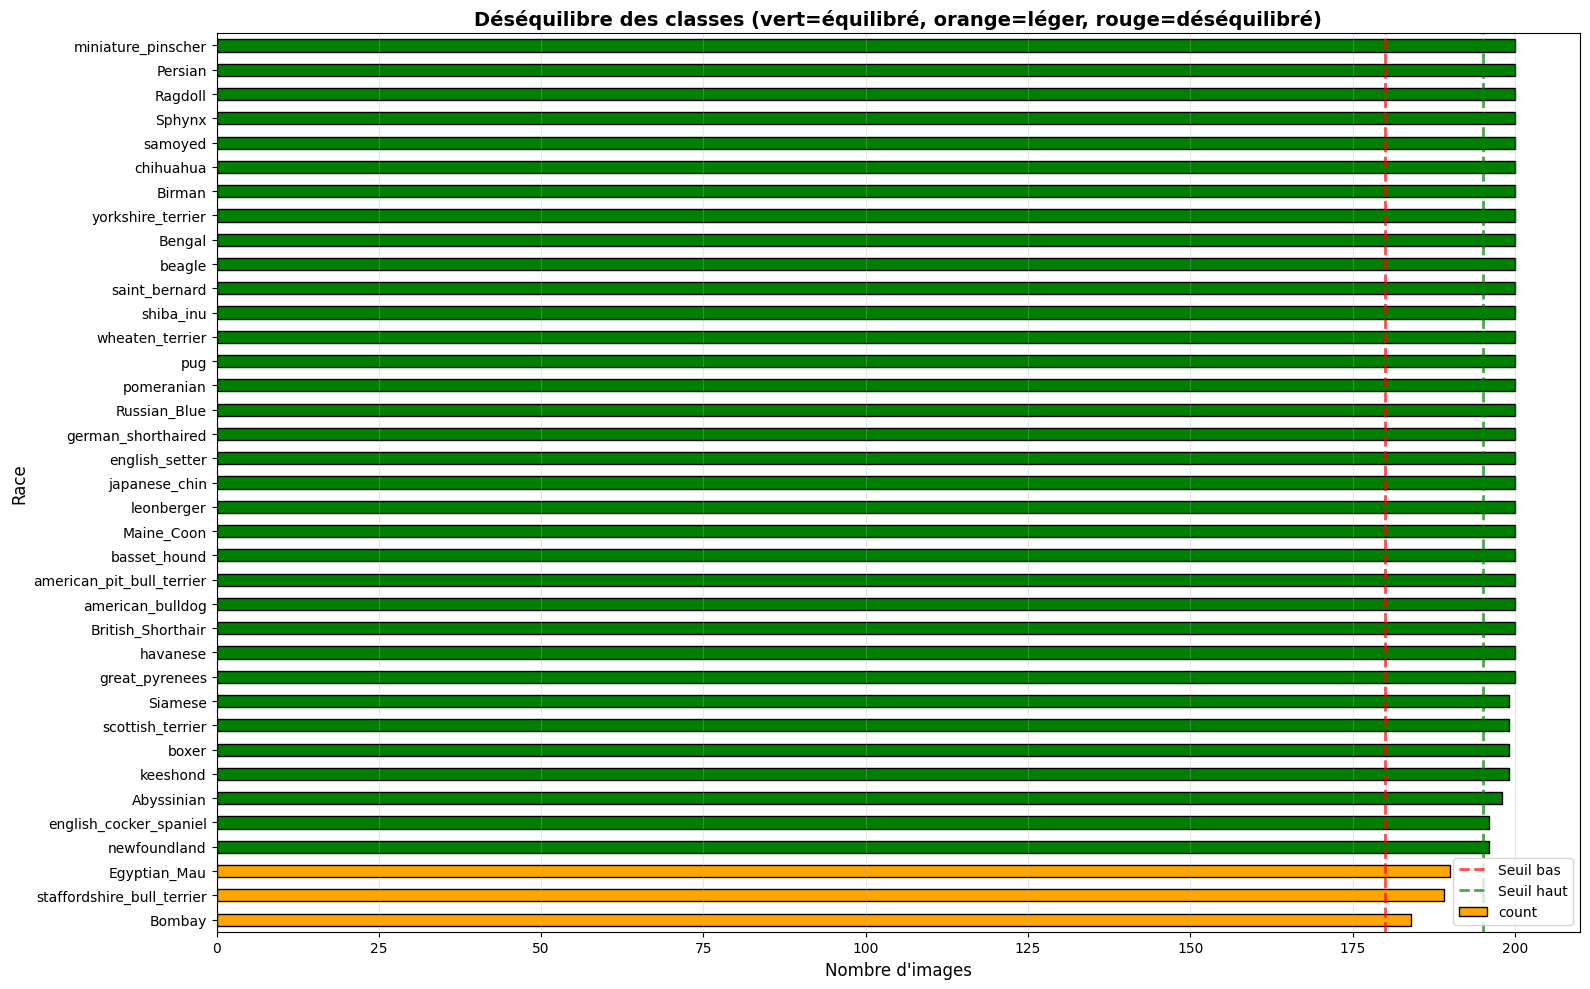

In [51]:
# Catégorisation
threshold_low = 180
threshold_high = 195

balanced = breed_counts[breed_counts >= threshold_high]
slightly_imbalanced = breed_counts[(breed_counts >= threshold_low) & (breed_counts < threshold_high)]
imbalanced = breed_counts[breed_counts < threshold_low]

print(f"Classes équilibrées (≥{threshold_high} images): {len(balanced)}")
print(f"Classes légèrement déséquilibrées ({threshold_low}-{threshold_high-1} images): {len(slightly_imbalanced)}")
print(f"Classes déséquilibrées (<{threshold_low} images): {len(imbalanced)}")

if len(imbalanced) > 0:
    print(f" Races les plus déséquilibrées:")
    print(imbalanced)

# Visualisation avec code couleur
fig, ax = plt.subplots(figsize=(16, 10))
colors_list = ['green' if x >= threshold_high else 'orange' if x >= threshold_low else 'red' 
               for x in breed_counts.sort_values()]
breed_counts.sort_values().plot(kind='barh', ax=ax, color=colors_list, edgecolor='black')
ax.set_title('Déséquilibre des classes (vert=équilibré, orange=léger, rouge=déséquilibré)', 
             fontsize=14, weight='bold')
ax.set_xlabel('Nombre d\'images', fontsize=12)
ax.set_ylabel('Race', fontsize=12)
ax.axvline(x=threshold_low, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Seuil bas')
ax.axvline(x=threshold_high, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Seuil haut')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### Répartition par race et par espèce


Nombre de races de chats: 12
Nombre de races de chiens: 25

Races de chats: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx']

Races de chiens: ['american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


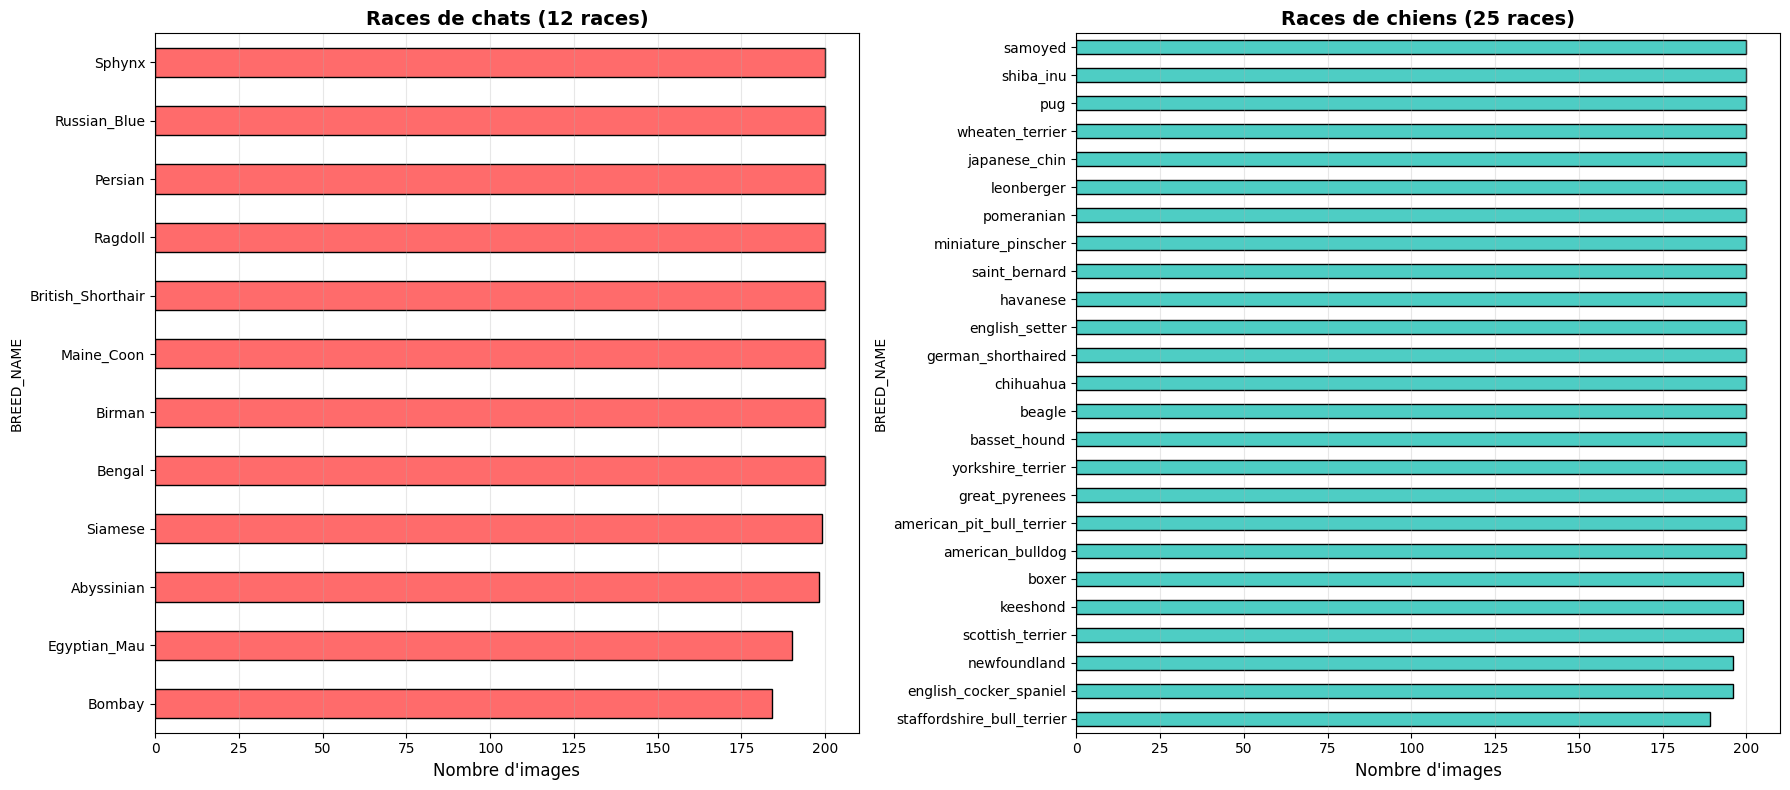

In [52]:
breed_species = df.groupby(['BREED_NAME', 'SPECIES_NAME']).size().reset_index(name='count')
cats_breeds = breed_species[breed_species['SPECIES_NAME'] == 'Cat']['BREED_NAME'].unique()
dogs_breeds = breed_species[breed_species['SPECIES_NAME'] == 'Dog']['BREED_NAME'].unique()

print(f"\nNombre de races de chats: {len(cats_breeds)}")
print(f"Nombre de races de chiens: {len(dogs_breeds)}")

print(f"\nRaces de chats: {sorted(cats_breeds)}")
print(f"\nRaces de chiens: {sorted(dogs_breeds)}")

# Visualisation séparée
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

cats_data = df[df['SPECIES_NAME'] == 'Cat']['BREED_NAME'].value_counts().sort_values()
dogs_data = df[df['SPECIES_NAME'] == 'Dog']['BREED_NAME'].value_counts().sort_values()

cats_data.plot(kind='barh', ax=axes[0], color='#FF6B6B', edgecolor='black')
axes[0].set_title(f'Races de chats ({len(cats_breeds)} races)', fontsize=14, weight='bold')
axes[0].set_xlabel('Nombre d\'images', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

dogs_data.plot(kind='barh', ax=axes[1], color='#4ECDC4', edgecolor='black')
axes[1].set_title(f'Races de chiens ({len(dogs_breeds)} races)', fontsize=14, weight='bold')
axes[1].set_xlabel('Nombre d\'images', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### Cohérence des masques de segmentation


Vérification en cours...
 Résultats (sur 100 images):
 Images présentes: 100/100 (100.0%)
 Masques présents: 100/100 (100.0%)
 Dimensions concordantes: 100/100 (100.0%)
 Masques valides (valeurs 1,2,3): 100/100 (100.0%)
  Visualisation d'exemples...
Visualisation des exemples terminée


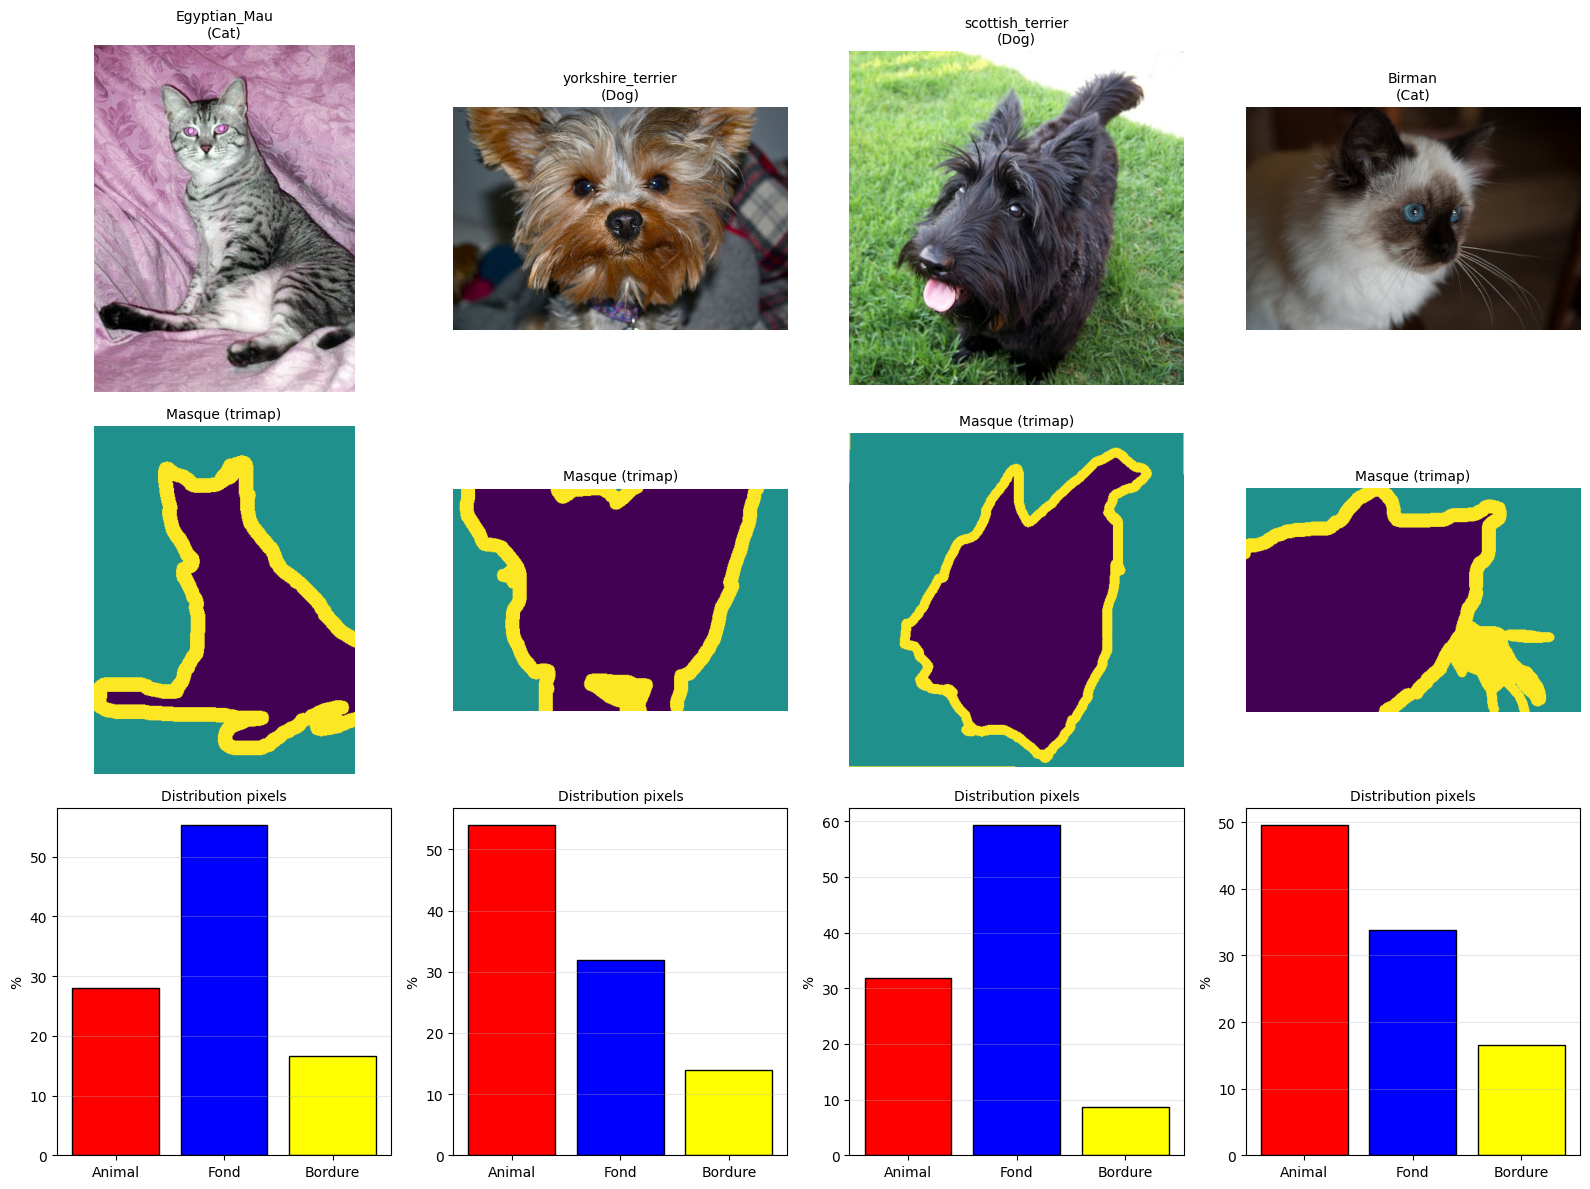

In [83]:
images_dir = "./oxford-iiit-pet/images"
masks_dir = "./oxford-iiit-pet/annotations/trimaps"

# Vérifier l'existence des fichiers
images_exist = []
masks_exist = []
dimensions_match = []
mask_quality = []

print("\nVérification en cours...")
sample_size = min(100, len(df))  # Échantillon pour test rapide

for idx, row in df.head(sample_size).iterrows():
    img_name = row['Image']
    mask_name = img_name.replace('.jpg', '.png')
    
    img_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)
    
    img_exists = os.path.exists(img_path)
    mask_exists = os.path.exists(mask_path)
    
    images_exist.append(img_exists)
    masks_exist.append(mask_exists)
    
    if img_exists and mask_exists:
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        dimensions_match.append(img.size == mask.size)
        
        # Vérifier valeurs du masque
        mask_array = np.array(mask)
        unique_vals = np.unique(mask_array)
        valid_mask = all(val in [1, 2, 3] for val in unique_vals)
        mask_quality.append(valid_mask)
    else:
        dimensions_match.append(False)
        mask_quality.append(False)

print(f" Résultats (sur {sample_size} images):")
print(f" Images présentes: {sum(images_exist)}/{sample_size} ({sum(images_exist)/sample_size*100:.1f}%)")
print(f" Masques présents: {sum(masks_exist)}/{sample_size} ({sum(masks_exist)/sample_size*100:.1f}%)")
print(f" Dimensions concordantes: {sum(dimensions_match)}/{sample_size} ({sum(dimensions_match)/sample_size*100:.1f}%)")
print(f" Masques valides (valeurs 1,2,3): {sum(mask_quality)}/{sample_size} ({sum(mask_quality)/sample_size*100:.1f}%)")

# Visualiser des exemples
print("  Visualisation d'exemples...")
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_indices = rd.sample(range(len(df)), 4)

for i, idx in enumerate(sample_indices):
    row = df.iloc[idx]
    img_name = row['Image']
    mask_name = img_name.replace('.jpg', '.png')
    
    img_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)
    
    if os.path.exists(img_path) and os.path.exists(mask_path):
        # Image originale
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"{row['BREED_NAME']}\n({row['SPECIES_NAME']})", fontsize=10)
        axes[0, i].axis('off')
        
        # Masque
        mask = np.array(Image.open(mask_path))
        axes[1, i].imshow(mask, cmap='viridis')
        axes[1, i].set_title('Masque (trimap)', fontsize=10)
        axes[1, i].axis('off')
        
        # Statistiques du masque
        unique, counts = np.unique(mask, return_counts=True)
        props = counts / mask.size * 100
        axes[2, i].bar(['Animal', 'Fond', 'Bordure'], props, 
                      color=['red', 'blue', 'yellow'], edgecolor='black')
        axes[2, i].set_ylabel('%')
        axes[2, i].set_title('Distribution pixels', fontsize=10)
        axes[2, i].grid(axis='y', alpha=0.3)

plt.tight_layout()
print("Visualisation des exemples terminée")
plt.show()

ANALYSE À FAIRE ==> LA NEIGE COMPLIQUÉ A VISUALISER MASQUE PAS FOU

### Classification binaire

On importe les données

In [84]:

base_path = "./oxford-iiit-pet/"
img_dir = os.path.join(base_path, "images/")
mask_dir = os.path.join(base_path, "annotations/trimaps/")



df['mask_filename'] = df['Image'].str.replace('.jpg', '.png')



# --- Division du Dataset (Train / Val / Test) ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['SPECIES_NAME'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['SPECIES_NAME'])

print(f"Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")

Train: 4703 | Validation: 1176 | Test: 1470


In [85]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 4703 validated image filenames belonging to 2 classes.
Found 1176 validated image filenames belonging to 2 classes.
Found 1470 validated image filenames belonging to 2 classes.


Ce code configure le pipeline de préparation des données pour la classification binaire (Chats vs Chiens). Il définit d'abord les hyperparamètres structurels, fixant la résolution des images à 150×150 pixels et la taille des lots (batch_size) à 20, une valeur choisie pour diviser exactement le nombre total d'échantillons. Trois instances d'ImageDataGenerator sont ensuite créées pour les ensembles d'entraînement, de validation et de test, appliquant uniquement une normalisation des pixels (rescale=1./255) pour ramener leurs valeurs dans l'intervalle [0,1]. La méthode flow_from_dataframe est utilisée pour générer les flux de données en associant les fichiers images du répertoire img_dir (colonne 'Image') à leurs étiquettes cibles (colonne 'SPECIES_NAME'). Enfin, le paramètre class_mode='binary' est spécifié pour encoder les étiquettes en format binaire, adaptant ainsi les données à une sortie à deux classes.

### CNN Simple

In [56]:
def cnn_simple(nom):
    # Initialisation du modèle Séquentiel (les couches s'empilent les unes après les autres)
    cnn = Sequential(name=nom)
    cnn.add(Input(shape=(img_width,img_height,3)))

    cnn.add(Conv2D(32, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(64, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(96, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    #cnn_simple.add(Conv2D(128, (3,3), activation='relu'))
    #cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Flatten())
    # cnn_simple.add(Dense(512, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    #cnn_simple.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid'))

    
    return cnn

In [57]:
cnn_naif=cnn_simple("cnn_simple")
cnn_naif.summary()        

Model: "cnn_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 27744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │     1,775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,850,529 (7.06 MB)

 Trainable params: 1,850,529 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
def Entrainement(cnn,train_generator, epochs=10, learn_rate = 3e-4):
    print("Entrainement de ",cnn.name)
    cnn.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=learn_rate),
        metrics = ['accuracy'])

    t_learning_cnn = time.time()
    
    cnn_history = cnn.fit(
        train_generator,
        validation_data = val_generator,
        epochs = epochs
    )
    
    t_learning_cnn = time.time() - t_learning_cnn
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn))
    
    return t_learning_cnn, cnn_history

In [59]:
t_learning_cnn_naif, cnn_naif_history = Entrainement(cnn_naif,train_generator)

Entrainement de  cnn_simple
Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.6938 - loss: 0.5785 - val_accuracy: 0.7338 - val_loss: 0.5139
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.7508 - loss: 0.5079 - val_accuracy: 0.7687 - val_loss: 0.4739
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.7863 - loss: 0.4593 - val_accuracy: 0.7466 - val_loss: 0.5017
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.8205 - loss: 0.4044 - val_accuracy: 0.7806 - val_loss: 0.4553
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.8537 - loss: 0.3434 - val_accuracy: 0.7883 - val_loss: 0.4542
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.8828 - loss: 0.2824 - val_accuracy: 0.8104 - val_loss: 0.4413
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.9156 - loss: 0.2148 - val_accuracy: 0.8010 - val_loss: 0.4766
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accura

In [60]:

def plot_training_analysis(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def Analyse_resultats(cnn,cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(val_generator, verbose=1)

    t_prediction_cnn = time.time() - t_prediction_cnn

    print('Train accuracy:', score_cnn_train[1])
    print('Validation accuracy:', score_cnn_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction_cnn)

    plot_training_analysis(cnn_history)
    return t_prediction_cnn

236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9879 - loss: 0.0441
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8002 - loss: 0.7468
Train accuracy: 0.9878800511360168
Validation accuracy: 0.8001700639724731
Time Prediction: 15.68 seconds


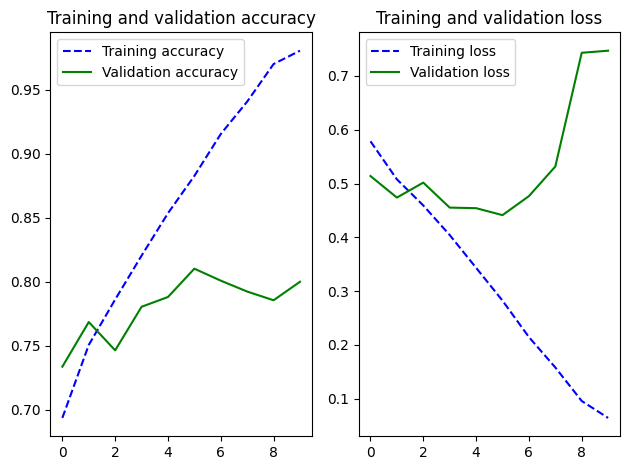

In [61]:
t_prediction_cnn_naif = Analyse_resultats(cnn_naif,cnn_naif_history)

train loss << val_loss  ==> overfitting ==> on va donc faire du dropout 


DROPOUT

In [62]:
def cnn_simple(nom):
    # Initialisation du modèle Séquentiel (les couches s'empilent les unes après les autres)
    cnn = Sequential(name=nom)
    cnn.add(Input(shape=(img_width,img_height,3)))

    cnn.add(Conv2D(32, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(64, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(96, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    #cnn_simple.add(Conv2D(128, (3,3), activation='relu'))
    #cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Flatten())
    # cnn_simple.add(Dense(512, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid'))

    
    return cnn

In [63]:
cnn_naif_dropout=cnn_simple("cnn_simple_dropout")
cnn_naif_dropout.summary() 

Model: "cnn_simple_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 27744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │     1,775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,850,529 (7.06 MB)

 Trainable params: 1,850,529 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
t_learning_cnn_naif_dropout, cnn_naif_dropout_history = Entrainement(cnn_naif_dropout,train_generator)

Entrainement de  cnn_simple_dropout
Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.6749 - loss: 0.6132 - val_accuracy: 0.6786 - val_loss: 0.5907
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.6942 - loss: 0.5585 - val_accuracy: 0.7032 - val_loss: 0.5262
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.7266 - loss: 0.5350 - val_accuracy: 0.7432 - val_loss: 0.5028
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.7510 - loss: 0.5082 - val_accuracy: 0.7789 - val_loss: 0.4674
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.7782 - loss: 0.4728 - val_accuracy: 0.7653 - val_loss: 0.4703
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.7961 - loss: 0.4329 - val_accuracy: 0.7679 - val_loss: 0.4655
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.8156 - loss: 0.4042 - val_accuracy: 0.7891 - val_loss: 0.4316
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step 

236/236 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9047 - loss: 0.2416
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8036 - loss: 0.4519
Train accuracy: 0.904741644859314
Validation accuracy: 0.8035714030265808
Time Prediction: 18.18 seconds


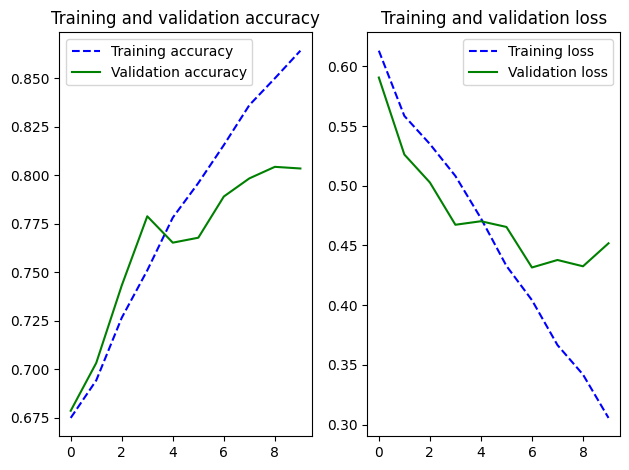

In [65]:
t_prediction_cnn_naif_dropout = Analyse_resultats(cnn_naif_dropout,cnn_naif_dropout_history)

### Amélioration 

### data augmentation

Définition : Technique consistant à créer des variantes artificielles des données d'entraînement (rotations, zooms, modifications de luminosité, etc.).

Objectif principal : Lutter contre le surapprentissage (overfitting) en augmentant artificiellement la taille du jeu de données.

Bénéfice : Améliore la robustesse et la capacité de généralisation du modèle en lui apprenant à ignorer les variations non pertinentes (ex: l'orientation d'un objet).

Application : Essentielle lorsque les données réelles sont limitées ou coûteuses à obtenir.

In [66]:
# Générateur avec Augmentation (Rotation, Zoom, Flip...)
aug_datagen = ImageDataGenerator(
    rotation_range = 10,
    rescale = 1./255,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range=[0.9,1.1], 
    channel_shift_range=10, 
    horizontal_flip = True,
    fill_mode='nearest'
)

# Seul le train est augmenté ! Val et Test restent "normaux"
train_gen_aug = aug_datagen.flow_from_dataframe(
    train_df, directory=img_dir, x_col='Image', y_col='SPECIES_NAME',
   target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary' 
)

# On réutilise le même modèle, mais entraîné sur des données augmentées
cnn_aug = cnn_simple("cnn_augmente")
temps_aug,history_aug = Entrainement(
    cnn_aug, 
    train_gen_aug,  
    epochs=30,  
    learn_rate=3e-4
)



Found 4703 validated image filenames belonging to 2 classes.
Entrainement de  cnn_augmente
Epoch 1/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.6762 - loss: 0.6159 - val_accuracy: 0.6777 - val_loss: 0.6093
Epoch 2/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.6887 - loss: 0.5725 - val_accuracy: 0.7041 - val_loss: 0.5382
Epoch 3/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 29s 122ms/step - accuracy: 0.7021 - loss: 0.5489 - val_accuracy: 0.7100 - val_loss: 0.5318
Epoch 4/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - accuracy: 0.7227 - loss: 0.5363 - val_accuracy: 0.7151 - val_loss: 0.5054
Epoch 5/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - accuracy: 0.7459 - loss: 0.5181 - val_accuracy: 0.7611 - val_loss: 0.4909
Epoch 6/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.7587 - loss: 0.4984 - val_accuracy: 0.7832 - val_loss: 0.4780
Epoch 7/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.7725 - loss: 0.4814 - val_accuracy: 0.8044 - val_loss:

236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8907 - loss: 0.2459
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8537 - loss: 0.3541
Train accuracy: 0.8907080292701721
Validation accuracy: 0.853741466999054
Time Prediction: 14.90 seconds


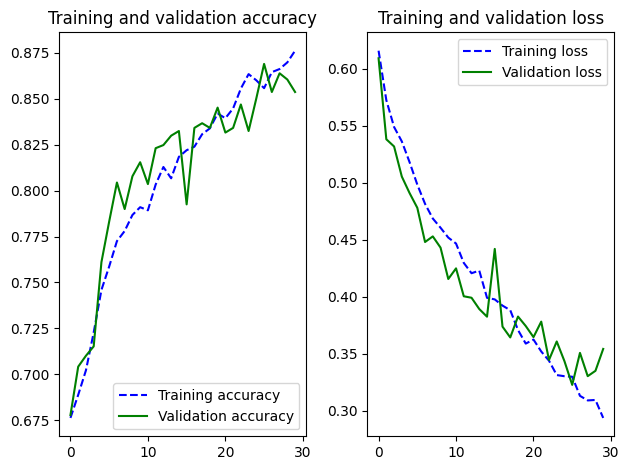

In [67]:
temps_prediction = Analyse_resultats(cnn_aug, history_aug)

Conclusion sur les premiers résultats et transition vers le Transfer Learning

Malgré la mise en place de stratégies de régularisation rigoureuses qui nous ont permi de limiter l'overfitting, notamment via la Data Augmentation (pour diversifier mon jeu de données) et l'ajout de couches Dropout (pour forcer le réseau à la robustesse), les performances de notre modèle restent insuffisantes. La loss stagne à un niveau trop élevé, ce qui indique que le problème ne vient plus uniquement du surapprentissage, mais probablement de la capacité limitée de l'architecture actuelle à extraire des caractéristiques pertinentes.

C'est pourquoi nous décidons de nous tourner vers une approche par Transfer Learning en utilisant le modèle pré-entraîné VGG16 pour les raisons suivantes :

- Au lieu de laisser notre modèle apprendre péniblement à reconnaître des formes basiques (bords, textures, contrastes), on utilise les poids optimisés de VGG16 sur ImageNet. Cela permet de bénéficier d'extracteurs de caractéristiques extrêmement performants dès le premier tour d'entraînement.

- Résolution du problème de convergence : VGG16, grâce à son architecture profonde et ses filtres déjà formés, offre un point de départ bien plus proche de la solution optimale, ce qui devrait mécaniquement faire chuter la loss.

- Optimisation de la capacité d'apprentissage : Tandis que nos efforts précédents (Dropout/Augmentation) visaient à limiter la mémorisation, l'utilisation de VGG16 vise à augmenter la qualité de la compréhension visuelle.

### Pre-trained Network

In [ ]:

def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

236/236 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,097,665 (8.00 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6502 - loss: 0.6714 - val_accuracy: 0.6777 - val_loss: 0.6297
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6749 - loss: 0.6327 - val_accuracy: 0.6777 - val_loss: 0.6393
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6743 - loss: 0.6278 - val_accuracy: 0.6777 - val_loss: 0.6444
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6804 - loss: 0.6161 - val_accuracy: 0.6735 - val_loss: 0.6377
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6840 - loss: 0.6037 - val_accuracy: 0.6769 - val_loss: 0.6404
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6881 - loss: 0.5910 - val_accuracy: 0.6624 - val_loss: 0.6394
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7015 - loss: 0.5793 - val_accuracy: 0.6276 - val_loss: 0.6582
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7112 - loss: 0.5648 - val_accuracy: 0.

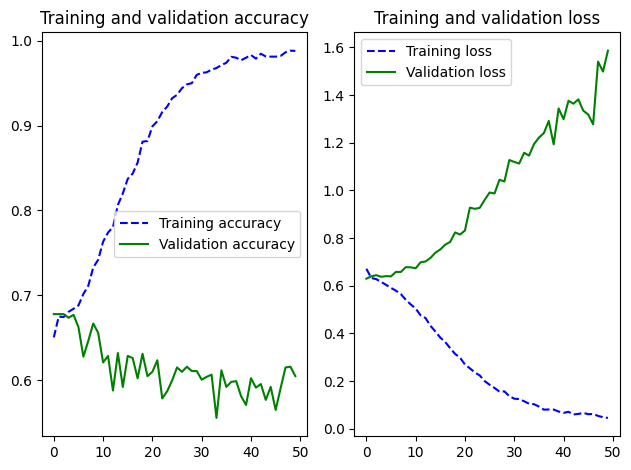

In [93]:
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

train_features = conv_base.predict(train_gen_aug)
train_features = np.reshape(train_features,(train_features.shape[0], -1))

validation_features = conv_base.predict(val_generator)
validation_features = np.reshape(validation_features,(validation_features.shape[0], -1))

#train_data = train_df.to_numpy()
#y_train = np.array([int(numeric_string) for numeric_string in train_data[:,2]]) -1

#validation_data = val_df.to_numpy()
#y_validation = np.array([int(numeric_string) for numeric_string in validation_data[:,2]]) -1

y_train = train_df['SPECIES'].values - 1  


y_validation = val_df['SPECIES'].values - 1

# Construction de la tête de classification
vgg_mlp = Sequential()
vgg_mlp.add( Input((train_features.shape[1],)) )
vgg_mlp.add(Dense(256, activation='relu'))
vgg_mlp.add(Dropout(0.5))
vgg_mlp.add(Dense(1, activation='sigmoid'))

vgg_mlp.summary()

# Compilation
epochs = 50
vgg_mlp.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=3e-4),
    metrics=['accuracy']
)

# Entraînement

t_learning_vgg_mlp = time.time()

vgg_mlp_history = vgg_mlp.fit(
    train_features, y_train,
    validation_data=(validation_features, y_validation),
    epochs=epochs,
)
t_prediction_vgg_mlp = time.time()

score_vgg_mlp_train = vgg_mlp.evaluate(train_features, y_train)
score_vgg_mlp_validation = vgg_mlp.evaluate(validation_features, y_validation)

t_prediction_vgg_mlp = time.time() - t_prediction_vgg_mlp

print('Train accuracy:', score_vgg_mlp_train[1])
print('Validation accuracy:', score_vgg_mlp_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_mlp )
plot_training_analysis(vgg_mlp_history)

In [91]:
print("Labels train uniques :", np.unique(y_train))
print("Labels val uniques :", np.unique(y_validation))
# Doit afficher [0 1]

Labels train uniques : [0 1]
Labels val uniques : [0 1]


fine tuning

### FINE TUNING SUR MODELE VGG 16 PRÉ ENTRAÎNÉ

In [43]:

vgg_combined_fine = clone_model(model_transfer)
vgg_combined_fine.set_weights(model_transfer.get_weights())


conv_base = next(layer for layer in vgg_combined_fine.layers if "vgg16" in layer.name.lower())
conv_base.trainable = True


for layer in conv_base.layers[:15]:
    layer.trainable = False

vgg_combined_fine.summary()

Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_337 (InputLayer)   │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,268,293 (111.65 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,422,020 (55.02 MB)

In [49]:
vgg_combined_history,t_learning_vgg_combined_augmented = Entrainement(vgg_combined_fine,train_gen_aug)

Entrainement de  VGG16_Transfer
Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.8203 - loss: 0.4228 - val_accuracy: 0.9218 - val_loss: 0.1959
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 31s 132ms/step - accuracy: 0.9137 - loss: 0.2111 - val_accuracy: 0.9218 - val_loss: 0.2019
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - accuracy: 0.9354 - loss: 0.1591 - val_accuracy: 0.9600 - val_loss: 0.1034
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 34s 146ms/step - accuracy: 0.9579 - loss: 0.1173 - val_accuracy: 0.9583 - val_loss: 0.1224
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.9585 - loss: 0.1082 - val_accuracy: 0.9558 - val_loss: 0.1158
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.9653 - loss: 0.0863 - val_accuracy: 0.9430 - val_loss: 0.1305
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - accuracy: 0.9751 - loss: 0.0732 - val_accuracy: 0.9532 - val_loss: 0.1146
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/s

236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.9940 - loss: 0.0144
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9583 - loss: 0.1294
Train accuracy: 0.9940463304519653
Validation accuracy: 0.9583333134651184
Time Prediction: 22.59 seconds


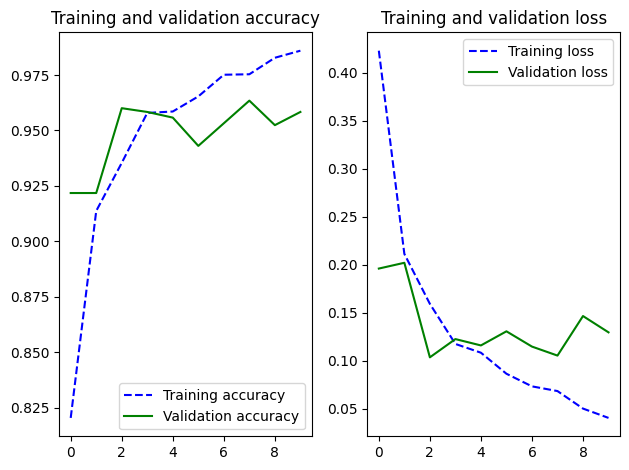

In [50]:
t_prediction_cnn_data_augmented = Analyse_resultats(vgg_combined_fine,vgg_combined_history)

on diminue le learning rate

In [51]:

vgg_combined_fine_plus = clone_model(vgg_combined_fine)
vgg_combined_fine_plus.set_weights(vgg_combined_fine.get_weights())

for layer in vgg_combined_fine_plus.layers:
    layer.trainable = True
    # Si une couche est un modèle (comme VGG16), il faut débloquer ses sous-couches aussi
    if hasattr(layer, "layers"):
        for sub_layer in layer.layers:
            sub_layer.trainable = True


vgg_combined_fine_plus.summary()

Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_337 (InputLayer)   │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,268,293 (111.65 MB)

 Trainable params: 14,846,273 (56.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,422,020 (55.02 MB)

In [52]:
vgg_combined_fine_plus_history,t_learning_vgg_combined_fine_plus = Entrainement(vgg_combined_fine_plus, train_gen_aug, epochs=4, learn_rate=1e-5)

Entrainement de  VGG16_Transfer
Epoch 1/4
236/236 ━━━━━━━━━━━━━━━━━━━━ 54s 166ms/step - accuracy: 0.9875 - loss: 0.0369 - val_accuracy: 0.9677 - val_loss: 0.1126
Epoch 2/4
236/236 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.9932 - loss: 0.0186 - val_accuracy: 0.9515 - val_loss: 0.1608
Epoch 3/4
236/236 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - accuracy: 0.9938 - loss: 0.0227 - val_accuracy: 0.9660 - val_loss: 0.1023
Epoch 4/4
236/236 ━━━━━━━━━━━━━━━━━━━━ 34s 142ms/step - accuracy: 0.9951 - loss: 0.0127 - val_accuracy: 0.9694 - val_loss: 0.1058
Learning time for 4 epochs : 153 seconds


236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.9974 - loss: 0.0069
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9694 - loss: 0.1058
Train accuracy: 0.9974484443664551
Validation accuracy: 0.9693877696990967
Time Prediction: 21.94 seconds


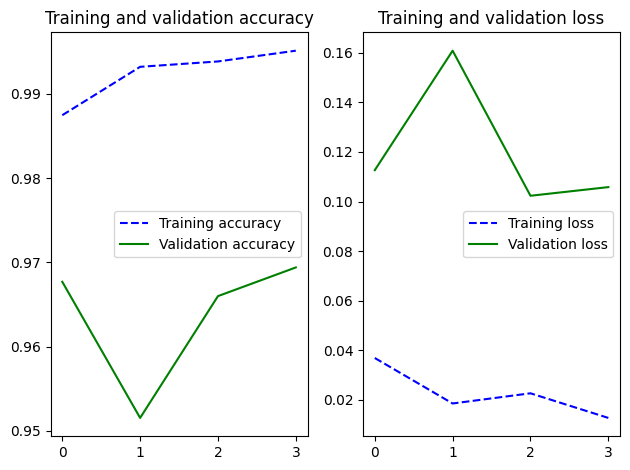

In [53]:
t_prediction_vgg_combined_fine_plus = Analyse_resultats(vgg_combined_fine_plus,vgg_combined_fine_plus_history)


precision au max => on va faire sur le test maintenant

74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step


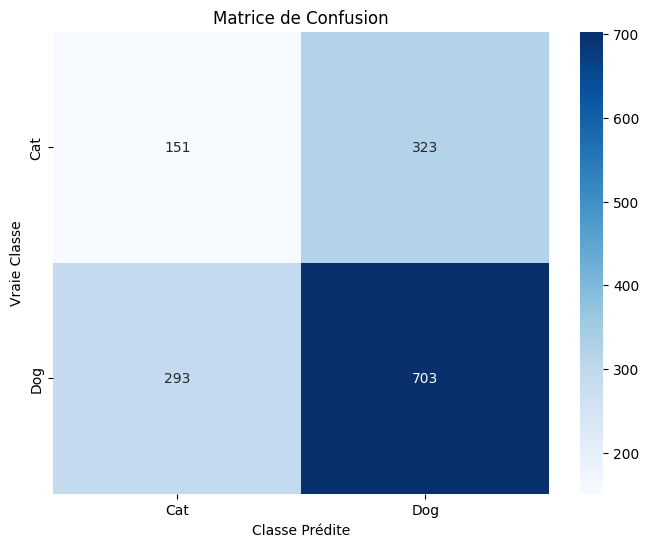


=== Rapport de Classification ===
              precision    recall  f1-score   support

         Cat       0.34      0.32      0.33       474
         Dog       0.69      0.71      0.70       996

    accuracy                           0.58      1470
   macro avg       0.51      0.51      0.51      1470
weighted avg       0.57      0.58      0.58      1470



In [55]:
test_generator.reset()
predictions = vgg_combined_fine_plus.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Vraies classes
true_classes = test_generator.classes

# Matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], 
            yticklabels=['Cat', 'Dog'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

# Rapport détaillé
print("\n=== Rapport de Classification ===")
print(classification_report(true_classes, predicted_classes, 
                          target_names=['Cat', 'Dog']))

74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step
Nombre d'erreurs : 652 / 1470


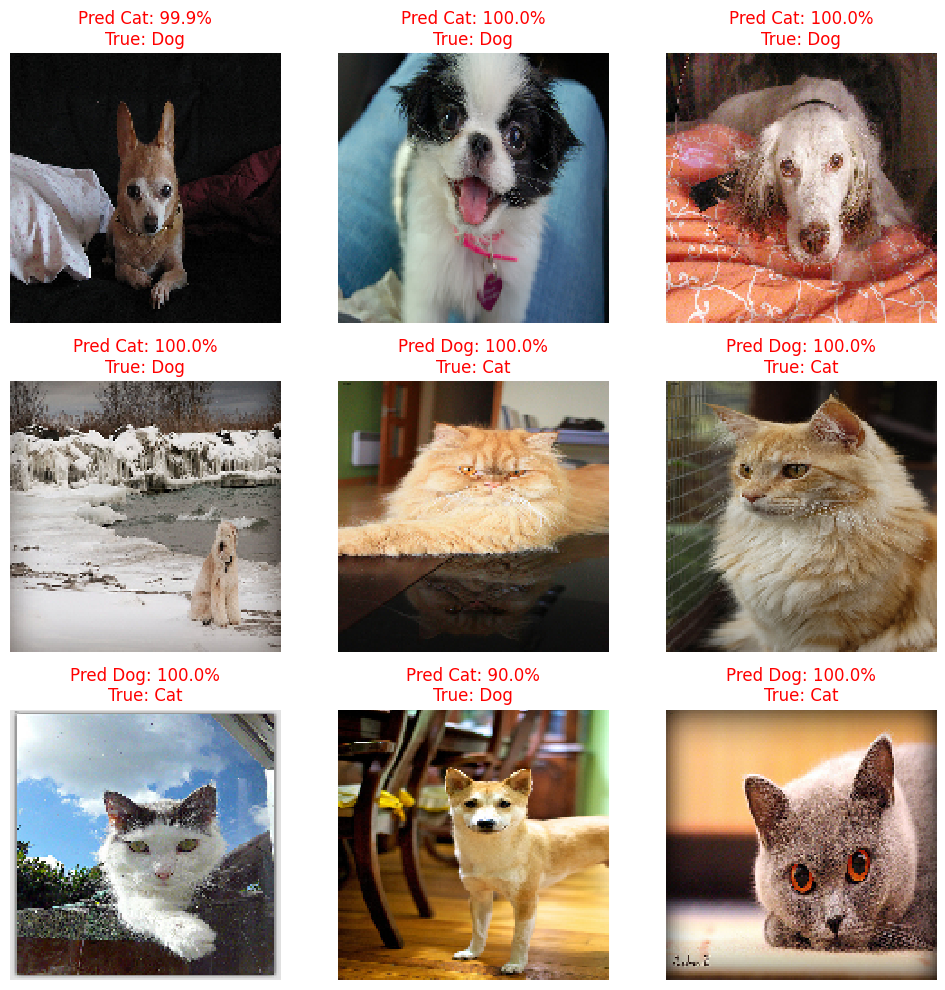

In [57]:
test_preds = vgg_combined_fine_plus.predict(test_generator)
y_true = test_generator.classes  # classes réelles
y_pred = (test_preds > 0.5).astype(int).flatten()  # prédictions binaires

# Identifier les erreurs
error_idx = np.where(y_true != y_pred)[0]
print(f"Nombre d'erreurs : {len(error_idx)} / {len(y_true)}")

# Visualiser quelques erreurs
n_errors_to_show = min(9, len(error_idx))
selected_errors = np.random.choice(error_idx, size=n_errors_to_show, replace=False)

fig = plt.figure(figsize=(10,10))

for i, idx in enumerate(selected_errors):
    # Charger l'image
    img = img_to_array(load_img(test_generator.filepaths[idx], target_size=(img_width, img_height)))/255
    
    pred_prob = test_preds[idx][0]
    
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img, interpolation='nearest')
    
    # Déterminer le titre et la couleur
    if pred_prob > 0.5:
        title = f"Pred Dog: {pred_prob*100:.1f}%\nTrue: {'Dog' if y_true[idx]==1 else 'Cat'}"
        color = "red" if y_true[idx]==0 else "green"
    else:
        title = f"Pred Cat: {(1-pred_prob)*100:.1f}%\nTrue: {'Cat' if y_true[idx]==0 else 'Dog'}"
        color = "red" if y_true[idx]==1 else "green"
    
    ax.set_title(title, color=color)
    ax.axis("off")

plt.tight_layout()
plt.show()


### Classification fine

In [61]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [62]:

# --- Paramètres ---
IMG_SIZE = (128, 128) # Réduit pour soulager le CPU/GPU
BATCH_SIZE = 32

# --- Générateurs (Data Augmentation vue en TP) ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Création du flux pour les RACES (Classification Fine) ---
# Pour Chats vs Chiens, changez juste y_col="SPECIES_NAME" et class_mode="binary"
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=img_dir,
    x_col="Image",
    y_col="BREED_NAME",      # Cible : Nom de la race
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical" # 37 classes
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=img_dir,
    x_col="Image",
    y_col="BREED_NAME",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# --- Modèle Transfer Learning (VGG16) ---
# Comme vu dans la section "Pre-trained Network" du TP
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # On gèle les poids

# Construction du classifier
x = base_model.output
x = GlobalAveragePooling2D()(x) # Ou Flatten() comme dans le TP simple
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(37, activation='softmax')(x) # 37 neurones pour les 37 races

model_clf = Model(inputs=base_model.input, outputs=predictions)

model_clf.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# model_clf.summary()
# history_clf = model_clf.fit(train_generator, validation_data=val_generator, epochs=10)

Found 4703 validated image filenames belonging to 37 classes.
Found 1176 validated image filenames belonging to 37 classes.


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step


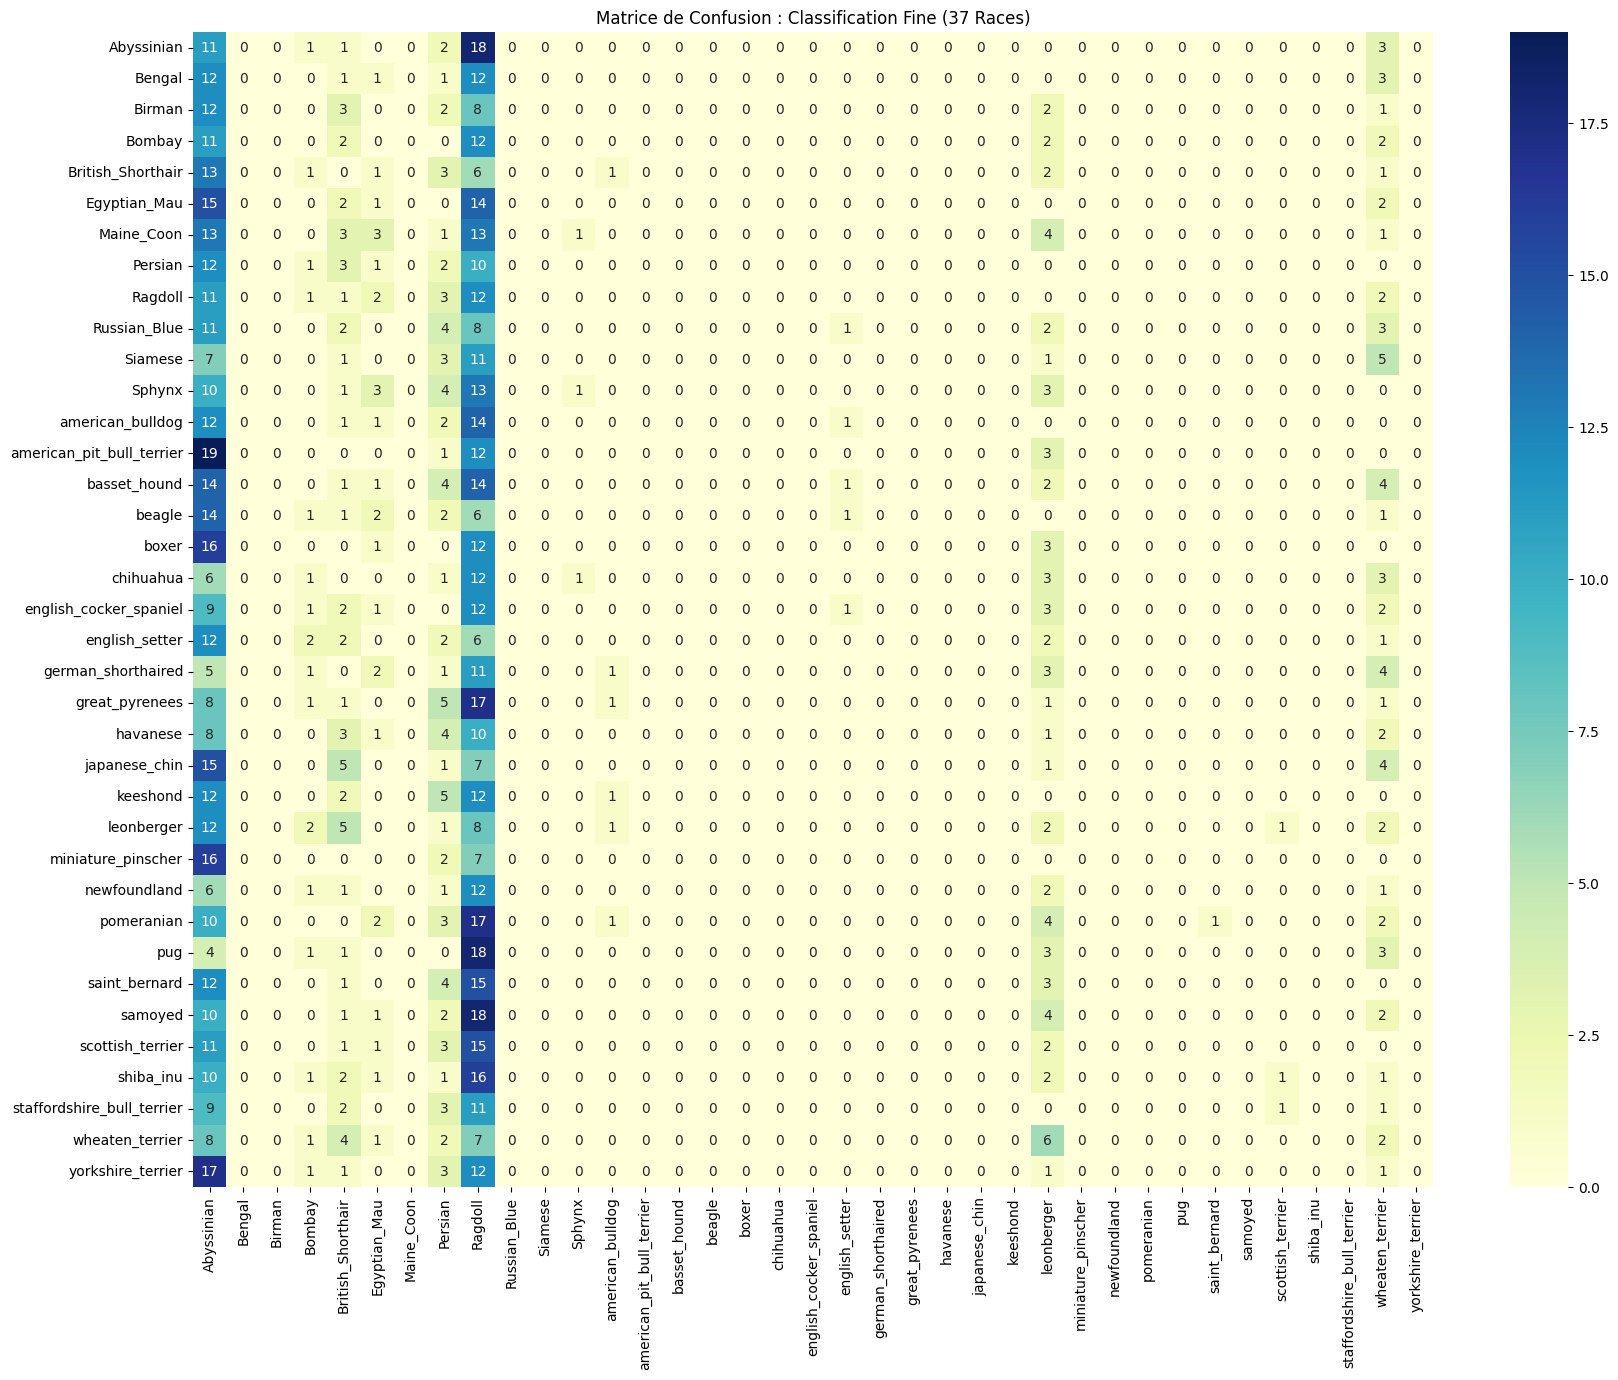

In [63]:
val_gen.reset()
preds = model_clf.predict(val_gen)
pred_classes = np.argmax(preds, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# 2. Créer la matrice
cm = confusion_matrix(true_classes, pred_classes)

# 3. Affichage large
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Matrice de Confusion : Classification Fine (37 Races)')
plt.show()

### data augmentation

In [66]:
aug_datagen_fine = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Un peu plus de rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Application sur le générateur de train
train_gen_fine = aug_datagen_fine.flow_from_dataframe(
    train_df,
    directory=img_dir,
    x_col='Image',
    y_col='BREED_NAME', 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4703 validated image filenames belonging to 37 classes.


In [67]:
# On gèle tout le backbone
base_model.trainable = False 

model_clf.compile(
    optimizer=Adam(learning_rate=1e-3), # Learning rate normal pour la tête
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraîner sur 5-10 époques
history_warmup = model_clf.fit(train_gen_fine, validation_data=val_gen, epochs=5)


Epoch 1/5


ValueError: Input 0 of layer "functional_41" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 150, 150, 3)

## Segmentation

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [ ]:

# --- Configuration des chemins (A ajuster selon votre dossier) ---
base_path = "./oxford-iiit-pet/"
img_dir = os.path.join(base_path, "images/")
mask_dir = os.path.join(base_path, "annotations/trimaps/")

# --- Ajout de la colonne des masques ---
# Les masques portent le même nom que l'image, mais en .png
# Votre colonne 'Image' contient déjà l'extension .jpg, on doit la remplacer
df['mask_filename'] = df['Image'].str.replace('.jpg', '.png')

# Vérification que les fichiers existent (optionnel mais recommandé)
# df = df[df['Image'].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))]

# --- Division du Dataset (Train / Val / Test) ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['SPECIES_NAME'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['SPECIES_NAME'])

print(f"Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")

#### Chargement des Données

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_data_in_ram(df, img_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    print(f"Chargement de {len(df)} images en cours...")
    
    count = 0
    for _, row in df.iterrows():
        # Chargement Image
        img_path = os.path.join(img_dir, row['Image'])
        img = load_img(img_path, target_size=img_size)
        images.append(img_to_array(img) / 255.0) # Normalisation [0, 1]
        
        # Chargement Masque
        mask_path = os.path.join(mask_dir, row['mask_filename'])
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        masks.append(img_to_array(mask) - 1) # Correction classes: 1,2,3 -> 0,1,2
        
        count += 1
        if count % 1000 == 0:
            print(f"{count} images traitées")
            
    return np.array(images), np.array(masks)

# Exécution du chargement
# IMG_SIZE doit correspondre à l'entrée de votre modèle (128, 128)
X_train, y_train = load_data_in_ram(train_df, img_dir, mask_dir)
X_val, y_val = load_data_in_ram(val_df, img_dir, mask_dir)

print("Chargement terminé.")
print(f"X_train shape: {X_train.shape}")

#### Implémentation du U-Net

L'architecture U-Net standard comprend une voie de contraction (encodeur) et une voie d'expansion (décodeur) avec des connexions résiduelles (skip connections).

In [ ]:
def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # --- Encodeur (Contraction) ---
    # Bloc 1
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Bloc 2
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bloc 3
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # --- Bottleneck ---
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    c4 = Dropout(0.3)(c4) # Pour éviter le surapprentissage

    # --- Décodeur (Expansion) ---
    # Bloc 5 (Up 1)
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3]) # Skip Connection
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    # Bloc 6 (Up 2)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2]) # Skip Connection
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    # Bloc 7 (Up 3)
    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1]) # Skip Connection
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    # --- Sortie ---
    # 3 classes : Animal, Background, Border -> Softmax
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Construction du modèle
model = build_unet(input_shape=IMG_SIZE + (3,), num_classes=3)
# model.summary()

#### Métriques

Pour compiler le modèle, nous devons définir des métriques adaptées à la segmentation sémantique.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    # On convertit les étiquettes en one-hot pour correspondre à la sortie softmax
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
    y_true_one_hot = tf.reshape(y_true_one_hot, shape=tf.shape(y_pred))
    
    intersection = K.sum(y_true_one_hot * y_pred, axis=[0,1,2])
    union = K.sum(y_true_one_hot, axis=[0,1,2]) + K.sum(y_pred, axis=[0,1,2])
    return K.mean( (2. * intersection + smooth) / (union + smooth) )

def iou_coef(y_true, y_pred, smooth=1):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
    y_true_one_hot = tf.reshape(y_true_one_hot, shape=tf.shape(y_pred))
    
    intersection = K.sum(K.abs(y_true_one_hot * y_pred), axis=[0,1,2])
    union = K.sum(y_true_one_hot,[0,1,2]) + K.sum(y_pred,[0,1,2]) - intersection
    return K.mean((intersection + smooth) / (union + smooth))

#### Entraînement

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', iou_coef, dice_coef])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=64, 
    epochs=15,
    callbacks=callbacks
)

#### Visualisation des résultats 

In [ ]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    iou = history.history['iou_coef']
    val_iou = history.history['val_iou_coef']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    # Courbe de perte
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Courbe IoU
    plt.subplot(1, 2, 2)
    plt.plot(epochs, iou, 'y', label='Training IoU')
    plt.plot(epochs, val_iou, 'r', label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.show()

plot_history(history)

Y'a du sur apprentissage, faut faire de la data augmentation puis si ca marche pas, augmenter le dropout.

In [ ]:
def display_prediction(generator, model, num_samples=10):
    x_val, y_val = generator.__getitem__(0) # Récupérer un batch
    preds = model.predict(x_val)
    
    # La prédiction brute est (128, 128, 3), on prend l'argmax pour avoir la classe (128, 128)
    preds_argmax = np.argmax(preds, axis=-1)
    
    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        # Image originale
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(x_val[i])
        plt.title("Image")
        plt.axis("off")

        # Vérité terrain (Mask)
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_val[i].squeeze(), cmap='jet', vmin=0, vmax=2)
        plt.title("Vérité Terrain")
        plt.axis("off")

        # Prédiction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds_argmax[i], cmap='jet', vmin=0, vmax=2)
        plt.title("Prédiction")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Test de visualisation
display_prediction(test_gen, model)